# Learning to Learn w\ Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_0.ipynb)

This it the first jupyter notebook used to familiarize with _Pennylane_ and _RNNs_ and _LSTMs_.

At first, the QAOA example for MAXCUT will be implemented.

**Run cell below only if using this notebook in Colab**  
Installing required dependencies and packages

In [ ]:
IS_COLAB = False
if IS_COLAB:
    !pip install --upgrade qiskit
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

import tensorflow as tf

import networkx as nx
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm

Set the seed for reproducibility of results

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Generation of data: graphs

Generation of a rangom graph $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of creation of an edge between two nodes

In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

Sample of a generted graph with 7 nodes and 6 edges (p=0.43)


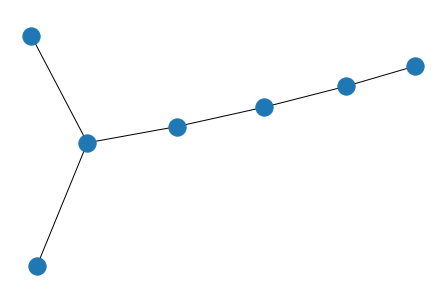

In [5]:
# Define parameters of the graph
n_graphs = 10
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a generted graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

## Creating QAOA circuit

In [6]:
# Number of qubits (wires) equal to the number of nodes in the graph
wires = range(len(graphs[0].nodes))

# Number of repetition in QAOA ansatze
num_p = 2

#Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)
     
# Creates the actual quantum circuit for the QAOA algorithm
def circuit(params, **kwargs): 
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, num_p, params[0], params[1])

In [7]:
def qaoa_from_graph(graph):
    """
    Creates a QAOA circuit instance of the MaxCut problem given a graph. Has nested function definitions needed for
    the creation of the circuit. When called, it instantiate a the structure of the circuit given the input graph,
    and outputs a function which needs only the parameters to be evaluated. 
    
    Args
    ------
    graph: Graph coming generated with networkx.
    
    Return
    ------
    hamiltonian: A function which, given params as input, evaluates the cost function of the 
                 QAOA qautntum circuit.
    
    """
        
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, 2, params[0], params[1])
     
    # Evaluates the cost function
    def hamiltonian(params, **kwargs):
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf",  diff_method = "backprop")
        return cost(params)
    
    return hamiltonian

#### Check the functioning

In [77]:
# Define some paramenters, in the form [gamma, alpha]
#x = tf.Variable([[1.,1.],[2.,2.]])
x = tf.Variable([[ 0.73965585,  0.19356517],[ -0.32492718, -0.11556163]])
#x = np.array([[1.,1.],[2.,2.]])

# Create an instance of a QAOA circuit given a graph
circ = qaoa_from_graph(graph = graphs[0])

# Evaluate the cost function given some angles for the QAOA instance just created
circ(x)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-4.58682894])>

#### Check evaluation of gradients

In [85]:
x = tf.Variable(np.array([[1.,1.],[2.,2.]]))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
step = 30

for _ in range(step):
    with tf.GradientTape() as tape:
        loss = circ(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"Final cost function: {circ(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-1.58033409]
Step 1 - Loss = [-2.28031059]
Step 2 - Loss = [-2.77674937]
Step 3 - Loss = [-2.99019258]
Step 4 - Loss = [-3.06969186]
Step 5 - Loss = [-3.13903264]
Step 6 - Loss = [-3.24393693]
Step 7 - Loss = [-3.40466788]
Step 8 - Loss = [-3.62411552]
Step 9 - Loss = [-3.86945053]
Step 10 - Loss = [-4.08737068]
Step 11 - Loss = [-4.25849342]
Step 12 - Loss = [-4.39410617]
Step 13 - Loss = [-4.47343245]
Step 14 - Loss = [-4.46684023]
Step 15 - Loss = [-4.42179723]
Step 16 - Loss = [-4.41561287]
Step 17 - Loss = [-4.45898908]
Step 18 - Loss = [-4.52085787]
Step 19 - Loss = [-4.57613137]
Step 20 - Loss = [-4.61329283]
Step 21 - Loss = [-4.62726392]
Step 22 - Loss = [-4.62011836]
Step 23 - Loss = [-4.60503914]
Step 24 - Loss = [-4.60207973]
Step 25 - Loss = [-4.6211883]
Step 26 - Loss = [-4.65368223]
Step 27 - Loss = [-4.68148368]
Step 28 - Loss = [-4.69135977]
Step 29 - Loss = [-4.68295294]
Final cost function: [-4.6665505]
Optimized angles: [[ 0.33100604 -0.66596012]
 [

## Recurrent Neural Network

Defining the custom LSTM architecture in Keras. It consists of a single step of an LSTM recurrent neural network.
An LSTMCell does just that.

In [49]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p = 2, graph = None):
        super(QRNN, self).__init__()
        # p is the number of layers in the QAOA ansatz
        self.cell = tf.keras.layers.LSTMCell(2*p)
        self.expectation = qaoa_from_graph(graph)

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]
        
        # Concatenate the previous parameters and previous cost to create new input
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
        # New parameters obtained by the LSTM cell, along with new internsal states: h and c
        new_params, [new_h, new_c] = self.cell(new_input, states = [prev_h, prev_c])
                
        # This part is used to feed the parameters to the Pennylane function
        _params = tf.reshape(new_params, shape = (2,2))
                
        # Cost evaluation, and reshaping to be consistent with other Keras tensors
        new_cost = tf.reshape(tf.cast(self.expectation(_params), 
                                      dtype=tf.float32),
                              shape = (1,1))
    
        return [new_cost, new_params, new_h, new_c]

Model: "custom_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
qrnn_19 (QRNN)               [(1, 1), (None, 4), (None 160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create some input layers to feed the datas
inp_cost = tf.keras.layers.Input(shape = (1,))
inp_params = tf.keras.layers.Input(shape = (4,))
inp_h = tf.keras.layers.Input(shape = (4,))
inp_c = tf.keras.layers.Input(shape = (4,))

model([inp_cost, inp_params, inp_h, inp_c])

In [96]:
n_qubits = 7

# Instanciate the lstm cells
rnn0 = QRNN(graph = graphs[0])

# Create some input layers to feed the datas
inp_cost = tf.keras.layers.Input(shape = (1,))
inp_params = tf.keras.layers.Input(shape = (4,))
inp_h = tf.keras.layers.Input(shape = (4,))
inp_c = tf.keras.layers.Input(shape = (4,))

# Manually creating the recurrent loops
out0 = rnn0([inp_cost, inp_params, inp_h, inp_c])
out1 = rnn0(out0)
out2 = rnn0(out1)

loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0]])

model = tf.keras.Model(inputs=[inp_cost, inp_params, inp_h, inp_c],
                       outputs=[out0[1], out1[1], out2[1], loss])

In [99]:
inp_costA = tf.zeros(shape = (1, 1))
inp_paramsA = tf.zeros(shape = (1, 4))
inp_hA = tf.zeros(shape = (1, 4))
inp_cA = tf.zeros(shape = (1, 4))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 5

for _ in range(step):
    with tf.GradientTape() as tape:
        pred = model(inputs)
        loss = pred[3]
            
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    print(f"Step {_} - Loss = {loss} - Cost = {circ(np.reshape(pred[2].numpy(),(2,2)))}")
    
print("Final Loss:", loss)
print("Final Outs:", pred)

Step 0 - Loss = [[-0.6520157]] - Cost = [-3.39023598]
Step 1 - Loss = [[-0.6592565]] - Cost = [-3.44210577]
Step 2 - Loss = [[-0.6667352]] - Cost = [-3.49517649]
Step 3 - Loss = [[-0.67443424]] - Cost = [-3.54931492]
Step 4 - Loss = [[-0.6823459]] - Cost = [-3.60448152]
Final Loss: tf.Tensor([[-0.6823459]], shape=(1, 1), dtype=float32)
Final Outs: [<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00932984,  0.01039701,  0.01025091, -0.01042722]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.06344067,  0.31056294,  0.05578193, -0.10402972]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.05273523,  0.42208984,  0.10471864, -0.1421794 ]],
      dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.6823459]], dtype=float32)>]


## Wrap the time-loop inside a custom model

#### Define a custom model, given a graph

In [180]:
class CustomModel(tf.keras.Model):
    def __init__(self, graph = None):
        super(CustomModel, self).__init__()
        self.custom_LSTMcell = QRNN(graph = graph)

    def call(self, inputs):
        out0 = self.custom_LSTMcell(inputs)
        out1 = self.custom_LSTMcell(out0)
        out2 = self.custom_LSTMcell(out1)
        loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0]])
    
        return [out0[1], out1[1], out2[1], loss]

#### Build all models

In [171]:
# Create some input layers to feed the datas
inp_cost = tf.keras.layers.Input(shape = (1,))
inp_params = tf.keras.layers.Input(shape = (4,))
inp_h = tf.keras.layers.Input(shape = (4,))
inp_c = tf.keras.layers.Input(shape = (4,))

num_models = 3
models = [CustomModel(graph = g) for g in graphs[:num_models]]

# Build all models
for model in models:
    model([inp_cost, inp_params, inp_h, inp_c])

#### Learning procedure

In [188]:
inp_costA = tf.zeros(shape = (1, 1))
inp_paramsA = tf.zeros(shape = (1, 4))
inp_hA = tf.zeros(shape = (1, 4))
inp_cA = tf.zeros(shape = (1, 4))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 2

num_models = 3
W = models[0].get_weights()

for epoch in range(2):
    print(f"Epoch: {epoch}")
    for i in range(num_models):
        models[i].set_weights(W)
        with tf.GradientTape() as tape:
            pred = models[i](inputs)
            loss = pred[3]
                
        gradients = tape.gradient(loss, models[i].trainable_variables)
        opt.apply_gradients(zip(gradients, models[i].trainable_variables))
        print(f"> Model {i} - Loss = {loss} - Cost = {qaoa_from_graph(graph = graphs[i])(np.reshape(pred[2].numpy(),(2,2)))}")
        W = models[i].get_weights()
    
print("Final Loss:", loss)
print("Final Outs:", pred)

Epoch: 0
> Model 0 - Loss = [[-0.6972899]] - Cost = [-3.70207851]
> Model 1 - Loss = [[-1.063217]] - Cost = [-5.44371483]
> Model 2 - Loss = [[-0.9829355]] - Cost = [-5.07984167]
Epoch: 1
> Model 0 - Loss = [[-0.721565]] - Cost = [-3.86318793]
> Model 1 - Loss = [[-1.0849468]] - Cost = [-5.58673628]
> Model 2 - Loss = [[-1.0067874]] - Cost = [-5.23442585]
Final Loss: tf.Tensor([[-1.0067874]], shape=(1, 1), dtype=float32)
Final Outs: [<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02763179, -0.02763112,  0.02762215,  0.02762665]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.0755222 , -0.14479722,  0.13831787,  0.09385875]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.10499392, -0.20244575,  0.18289888,  0.10942326]],
      dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.0067874]], dtype=float32)>]


In [ ]:
inp_costA = tf.zeros(shape = (1, 1))
inp_paramsA = tf.zeros(shape = (1, 4))
inp_hA = tf.zeros(shape = (1, 4))
inp_cA = tf.zeros(shape = (1, 4))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 2

num_models = 3
W = models[0].get_weights()

for epoch in range(2):
    print(f"Epoch: {epoch}")
    for i in range(num_models):
        models[i].set_weights(W)
        with tf.GradientTape() as tape:
            pred = models[i](inputs)
            loss = pred[3]
                
        gradients = tape.gradient(loss, models[i].trainable_variables)
        opt.apply_gradients(zip(gradients, models[i].trainable_variables))
        print(f"> Model {i} - Loss = {loss} - Cost = {qaoa_from_graph(graph = graphs[i])(np.reshape(pred[2].numpy(),(2,2)))}")
        W = models[i].get_weights()
    
print("Final Loss:", loss)
print("Final Outs:", pred)

In [168]:
def shareWeightsModel(model, targetModel):
    modelWeights       = model.trainable_weights
    targetModelWeights = targetModel.trainable_weights

    for i in range(len(targetModelWeights)):
        targetModelWeights[i].assign(modelWeights[i])
        
for model in models:
    updateTargetModel(models[-1], model)

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([2, 2, 2], dtype=int32)>

In [25]:
@tf.function
def value_loss(unused, outputs):
    return tf.reduce_mean(outputs)

# It's important to have a good guess on the last shot of the optimization
loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0]])

# Penalize jumping around randomly in the landscape.
# Add penalizer

full_loss = loss #+ penalizer

In [26]:
# Can change these to random along with longer tine horizon and greater training
# data for more robust test set performance

# Our model will output it's parameter guesses along with the loss value that is
# computed over them. This way we can use the model to guess parameters later on
model = tf.keras.Model(inputs=[inp_cost, inp_params, inp_h, inp_c],
                       outputs=[out0[1], out1[1], out2[1], full_loss])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=value_loss, loss_weights=[0, 0, 0, 1])

In [29]:
N_POINTS = 10

inp_costA = tf.zeros(shape = (N_POINTS, 1))
inp_paramsA = tf.zeros(shape = (N_POINTS, 4))
inp_hA = tf.zeros(shape = (N_POINTS, 4))
inp_cA = tf.zeros(shape = (N_POINTS, 4))

model.fit(x=[inp_costA, inp_paramsA, inp_hA, inp_cA],
          y=[
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1)),
              np.zeros((N_POINTS, 1))
          ],
          epochs=3,
          batch_size=5,
          verbose=1)

Epoch 1/3


ValueError: in user code:

    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-10-ebacd62dde43>:24 call  *
        _params = tf.reshape(new_params, shape = (2,2))
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:8234 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 20 elements to shape [2,2] (4 elements) for '{{node functional_1/qrnn_4/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](functional_1/qrnn_4/lstm_cell_4/mul_2, functional_1/qrnn_4/Reshape/shape)' with input shapes: [5,4], [2] and with input tensors computed as partial shapes: input[1] = [2,2].


In [11]:
model = tf.keras.Model(inputs = [inp_cost, inp_params, inp_h, inp_c], outputs = out2)

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4)]          0                                            
_______________________________________________________________________________________

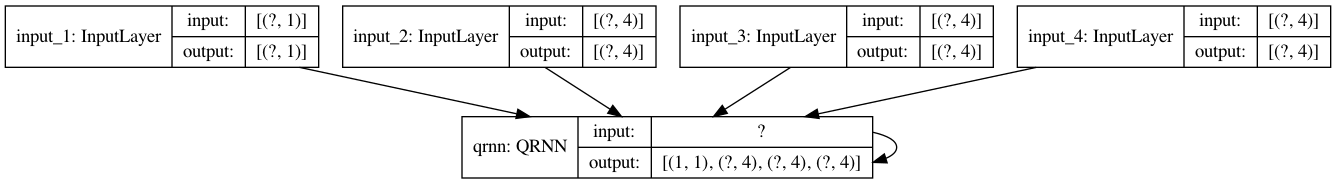

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
[QRNN(graph = graphs[0]) for i in range(2)]

[<__main__.QRNN at 0x7fc64cc3bed0>, <__main__.QRNN at 0x7fc6ada45f90>]

In [ ]:
def create_model(num_qubits = 7, cycles = 5, graph = None):
    q_cells = [QRNN(graph = graph) for i in range(cycles)]
    

## Test code (can ignore)

In [ ]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit.tf", wires=7, analytic=True)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=2, graph = None):
    
    n_wires = len(graph.nodes)
    
    # unitary operator U_B with parameter beta
    def U_B(beta):
        for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

    # unitary operator U_C with parameter gamma
    def U_C(gamma):
        for edge in graph.edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])
            
    def comp_basis_measurement(wires):
        n_wires = len(wires)
        return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)    
    
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [16]:
cell0 = tf.keras.layers.LSTMCell(4)
cell1 = tf.keras.layers.LSTMCell(4)
cell2 = tf.keras.layers.LSTMCell(4)

output, [h, c] = cell0(tf.ones(shape=(1,5)), states = [tf.zeros(shape=(1,4)), tf.zeros(shape=(1,4))])
#output, [h, c] = cell1(output, states = [h, c])
#output, [h, c] = cell2(output, states = [h, c])


print(output, h, c)

tf.Tensor([[ 0.01506045  0.08822118  0.01831053 -0.30537358]], shape=(1, 4), dtype=float32) tf.Tensor([[ 0.01506045  0.08822118  0.01831053 -0.30537358]], shape=(1, 4), dtype=float32) tf.Tensor([[ 0.03009109  0.2579358   0.03984904 -0.6119622 ]], shape=(1, 4), dtype=float32)


In [34]:
cell = tf.keras.layers.LSTMCell(4)
self.expectation = qaoa_from_graph(graph)

f call(self, inputs):
prev_cost = inputs[0]
prev_params = inputs[1]
prev_h = inputs[2]
prev_c = inputs[3]

new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
new_params, new_h, new_c = self.cell(new_input, state = [prev_h, prev_c])

new_cost = self.expectation([new_params[:2], new_params[2:]])

return [new_cost, new_params, new_h, new_c]

SyntaxError: invalid syntax (<ipython-input-34-8abbfdd40d59>, line 4)

In [10]:
cost_inp = tf.keras.Input(shape=(1,))
params_inp = tf.keras.Input(shape=(2,2))
h_inp = tf.keras.Input(shape=(4,)) # it has the shape (batch, units)
c_inp = tf.keras.Input(shape=(4,))

In [147]:
def generate_dataset(num_qubits, num_data):
    p_edge = 3./num_qubits
    circs = []
    for _ in range(num_data):
        random_graph = nx.gnp_random_graph(num_qubits, p = p_edge)
        circ = qaoa_from_graph(random_graph)
        circs.append(circ)
    return circs

In [148]:
circs = generate_dataset(5, 10)

## Mapping of Graph to QAOA anstaze

How to create a circuit in Pennylane

In [88]:
dev = qml.device('default.qubit', wires=2, shots=1024, analytic=False)

@qml.qnode(dev)
def circuit():
    qml.PauliX(1)
    qml.Hadamard(0)
    return qml.expval(qml.PauliZ(1))

circuit()
print(circuit.draw())

 0: ──H──┤     
 1: ──X──┤ ⟨Z⟩ 



In [180]:
# Transverse field
def U_x(eta, n_wires = None):
    for wire in range(n_wires):
        qml.RX(2 * eta, wires = wire)

# Actual hamiltonian
def U_C(gamma, graph = None):
    for edge in graph.edges():
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def qaoa_from_graph(alphas, betas, graph = None, p = None):
    n_qubits = len(graph.nodes)
    
    # All qubits to |+> state
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Repeat QAOA ansatze p times
    for n_layers in range(p):
        for e in graph.edges():
            qml.CZ(wires = [e[0], e[1]])
            
    # Final measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

dev = dev = qml.device('default.qubit', wires=7, shots=1024, analytic=False)

qnode = qml.QNode(qaoa_from_graph, dev)

qnode(0., 0., graph = graphs[0], p = 1)

print(qnode.draw())

 0: ──H──╭C──╭C──────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰Z──│───╭C──────╭C──────╭C──────────────────┤ ⟨Z⟩ 
 2: ──H──────│───│───╭C──│───╭C──│───────╭C──────────┤ ⟨Z⟩ 
 3: ──H──────╰Z──╰Z──╰Z──│───│───│───╭C──│───────────┤ ⟨Z⟩ 
 4: ──H──────────────────╰Z──╰Z──│───╰Z──│───╭C──────┤ ⟨Z⟩ 
 5: ──H──────────────────────────│───────│───│───╭C──┤ ⟨Z⟩ 
 6: ──H──────────────────────────╰Z──────╰Z──╰Z──╰Z──┤ ⟨Z⟩ 

